# Generate transformation

# Read and Plot Transformation

# Daniel Code

0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000


/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_15985/2874260760.py:146: UserWarning: No contour levels were found within the data range.
  ax.contour(phii[v.shape[0]//2,...,0],levels,colors='r',linestyles='-')


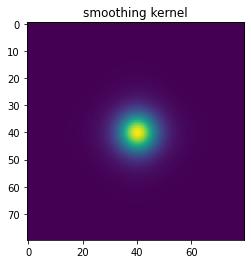

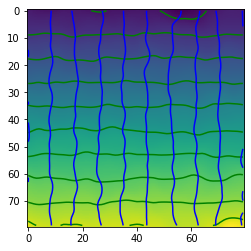

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

def interp(points, values, xi):
    values = values.detach().cpu().numpy()
    xi = xi.detach().cpu().numpy()

    return torch.tensor(interpn(points, values, xi, bounds_error=False, fill_value=None))

def expR(xv,v0,K,n=10,visualize=False,return_forward=True):
    '''
    Riemannian exponential, todo

    Parameters
    ----------
    xv : list of arrays
        Location of pixels in v.
    v : velocity at time 0
        Recall shape is rowxcolxsicex3
    K : array
        kernel in fft domain
    n : int
        number of timesteps

    visualie : bool
        only supported with no batch

    Returns
    -------
    phii : array
        inverse deformation used to transform images
    Notes
    -----
    pt = Dphi^{-T}(phi_t^{-1}) p0(phi_t^{-1})|Dphii^{-1}|
        = Dphii^{T} p0(phii)|Dphii^{-1}|
    '''

    use_batch = v0.ndim==5
    if not use_batch:
        permute0 = (-4,-3,-2,-1)#(-1,-4,-3,-2)
        permute1 = (-4,-3,-2,-1)#(-3,-2,-1,-4)
    else:
        permute0 = (0,-1,-4,-3,-2)
        permute1 = (0,-3,-2,-1,-4)


    # initialize p at time 0
    p0 = torch.fft.ifftn(torch.fft.fftn(v0,dim=(-2,-3,-4))/K[...,None],dim=(-2,-3,-4)).real
    # initialize phii at time 0
    XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)
    # initialize dv
    dv = [x[1].item() - x[0].item() for x in xv]

    phii = XV.clone()
    if use_batch:
        phii = phii[None].repeat(v0.shape[0],1,1,1,1)
        XV = XV[None].repeat(v0.shape[0],1,1,1,1)


    if visualize and not use_batch:
        fig,ax = plt.subplots(1,3)

    # we take n timesteps

    if return_forward:
        vsave = []
    for t in range(n):
        # we need to calculate p at time t
        # first we just deform it
        p = interp(xv,p0.permute(*permute0),phii).permute(*permute1)
        # then we need the jacobian
        Dphii = torch.stack(torch.gradient(phii,dim=(-4,-3,-2),spacing=dv),-1)
        # and the determinant (over the last two axes)
        detDphii = torch.linalg.det(Dphii)
        # then we will multiply

        p = (Dphii.transpose(-1,-2)@p[...,None])[...,0]*detDphii[...,None]
        # now we calculate v
        v = torch.fft.ifftn(torch.fft.fftn(p,dim=(-2,-3,-4))*K[...,None],dim=(-2,-3,-4)).real
        if return_forward:
            vsave.append(v)
        # now we update phii
        Xs = XV-v/n
        phii = interp(xv,(phii - XV).permute(*permute0),Xs).permute(*permute1) + Xs
        print(f"{torch.sum(torch.isnan(phii))} nans out of {np.product(phii.shape)}")
        
        if visualize and not use_batch:
            pshow = np.array(p[p0.shape[1]//2,:,:,:])
            pshow -= np.min(pshow,axis=(0,1,2))
            pshow /= np.max(pshow,axis=(0,1,2))
            ax[0].cla()
            ax[0].imshow(pshow)

            vshow = np.array(v[p0.shape[1]//2,:,:,:])
            vshow -= np.min(vshow,axis=(0,1,2))
            vshow /= np.max(vshow,axis=(0,1,2))
            ax[1].cla()
            ax[1].imshow(vshow)

            fig.canvas.draw()
    if not return_forward:
        return phii
    else:
        phi = XV.clone()
        for v in reversed(vsave):
            Xs = XV+v/n
            phi = interp(xv,(phii - XV).permute(*permute0),Xs).permute(*permute1) + Xs
        return phi




# a domain for sampling your velocity and deformatoin
dv = np.array([5.0,5.0,5.0])
nv = np.array([80,80,80])
xv = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nv,dv)]
XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)

# a frequency domain
fv = [np.arange(n)/n/d for n,d in zip(nv,dv)]
FV = np.stack(np.meshgrid(*fv,indexing='ij'),-1)
a = 5.0
p = 2.0
LL = (1.0 - 2.0*a**2*np.sum(((np.cos(2.0*np.pi*FV*dv)   - 1))/dv**2,-1))**(2*p)
K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(np.fft.ifftshift(K[0]))
ax.set_title('smoothing kernel')


# lets make a new p which is really simple for testing
# sample white noise
Lm = np.random.randn(*FV.shape)*90

# smooth it with sqrt(K) (here I smoothed with K to be a bit smoother)
v = np.fft.ifftn(np.fft.fftn(Lm,axes=(0,1,2))*K[...,None],axes=(0,1,2)).real

#shoot it with remannian exponential
phii = expR([torch.tensor(x) for x in xv],torch.tensor(v),K,n=10)

fig,ax = plt.subplots()
levels = np.linspace(-200,200,10)
ax.imshow(phii[v.shape[0]//2,...,1])
ax.contour(phii[v.shape[0]//2,...,0],levels,colors='r',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,1],levels,colors='g',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,2],levels,colors='b',linestyles='-')

In [2]:
phii[0:2,0,0,:]

tensor([[-204.5075, -194.4524, -193.5265],
        [-198.9138, -193.9920, -193.0160]], dtype=torch.float64)

In [3]:
XV[0:2,0,0,:]

tensor([[-197.5000, -197.5000, -197.5000],
        [-192.5000, -197.5000, -197.5000]], dtype=torch.float64)

In [4]:
phii = phii.detach().cpu().numpy()

In [5]:
from scipy.interpolate import (
    BSpline,
    splev,
    CubicHermiteSpline,
    RegularGridInterpolator,
)
F = RegularGridInterpolator([xv[0],xv[1],xv[2]], phii)
F(XV[0:2,0,0,:])

array([[-204.50750191, -194.45243043, -193.52650315],
       [-198.91383838, -193.99204495, -193.01600182]])

In [6]:
from scipy.spatial.distance import cosine
from brainlit.map_neurons import Diffeomorphism_Transform

In [7]:
ct = Diffeomorphism_Transform(xv, phii)


average squared deformation 40.20984591970824
average 1-cosine between derivatives 0.008789383218348486


/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_15985/4191743048.py:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


<mpl_toolkits.mplot3d.art3d.Line3DCollection object at 0x167b4ef40>

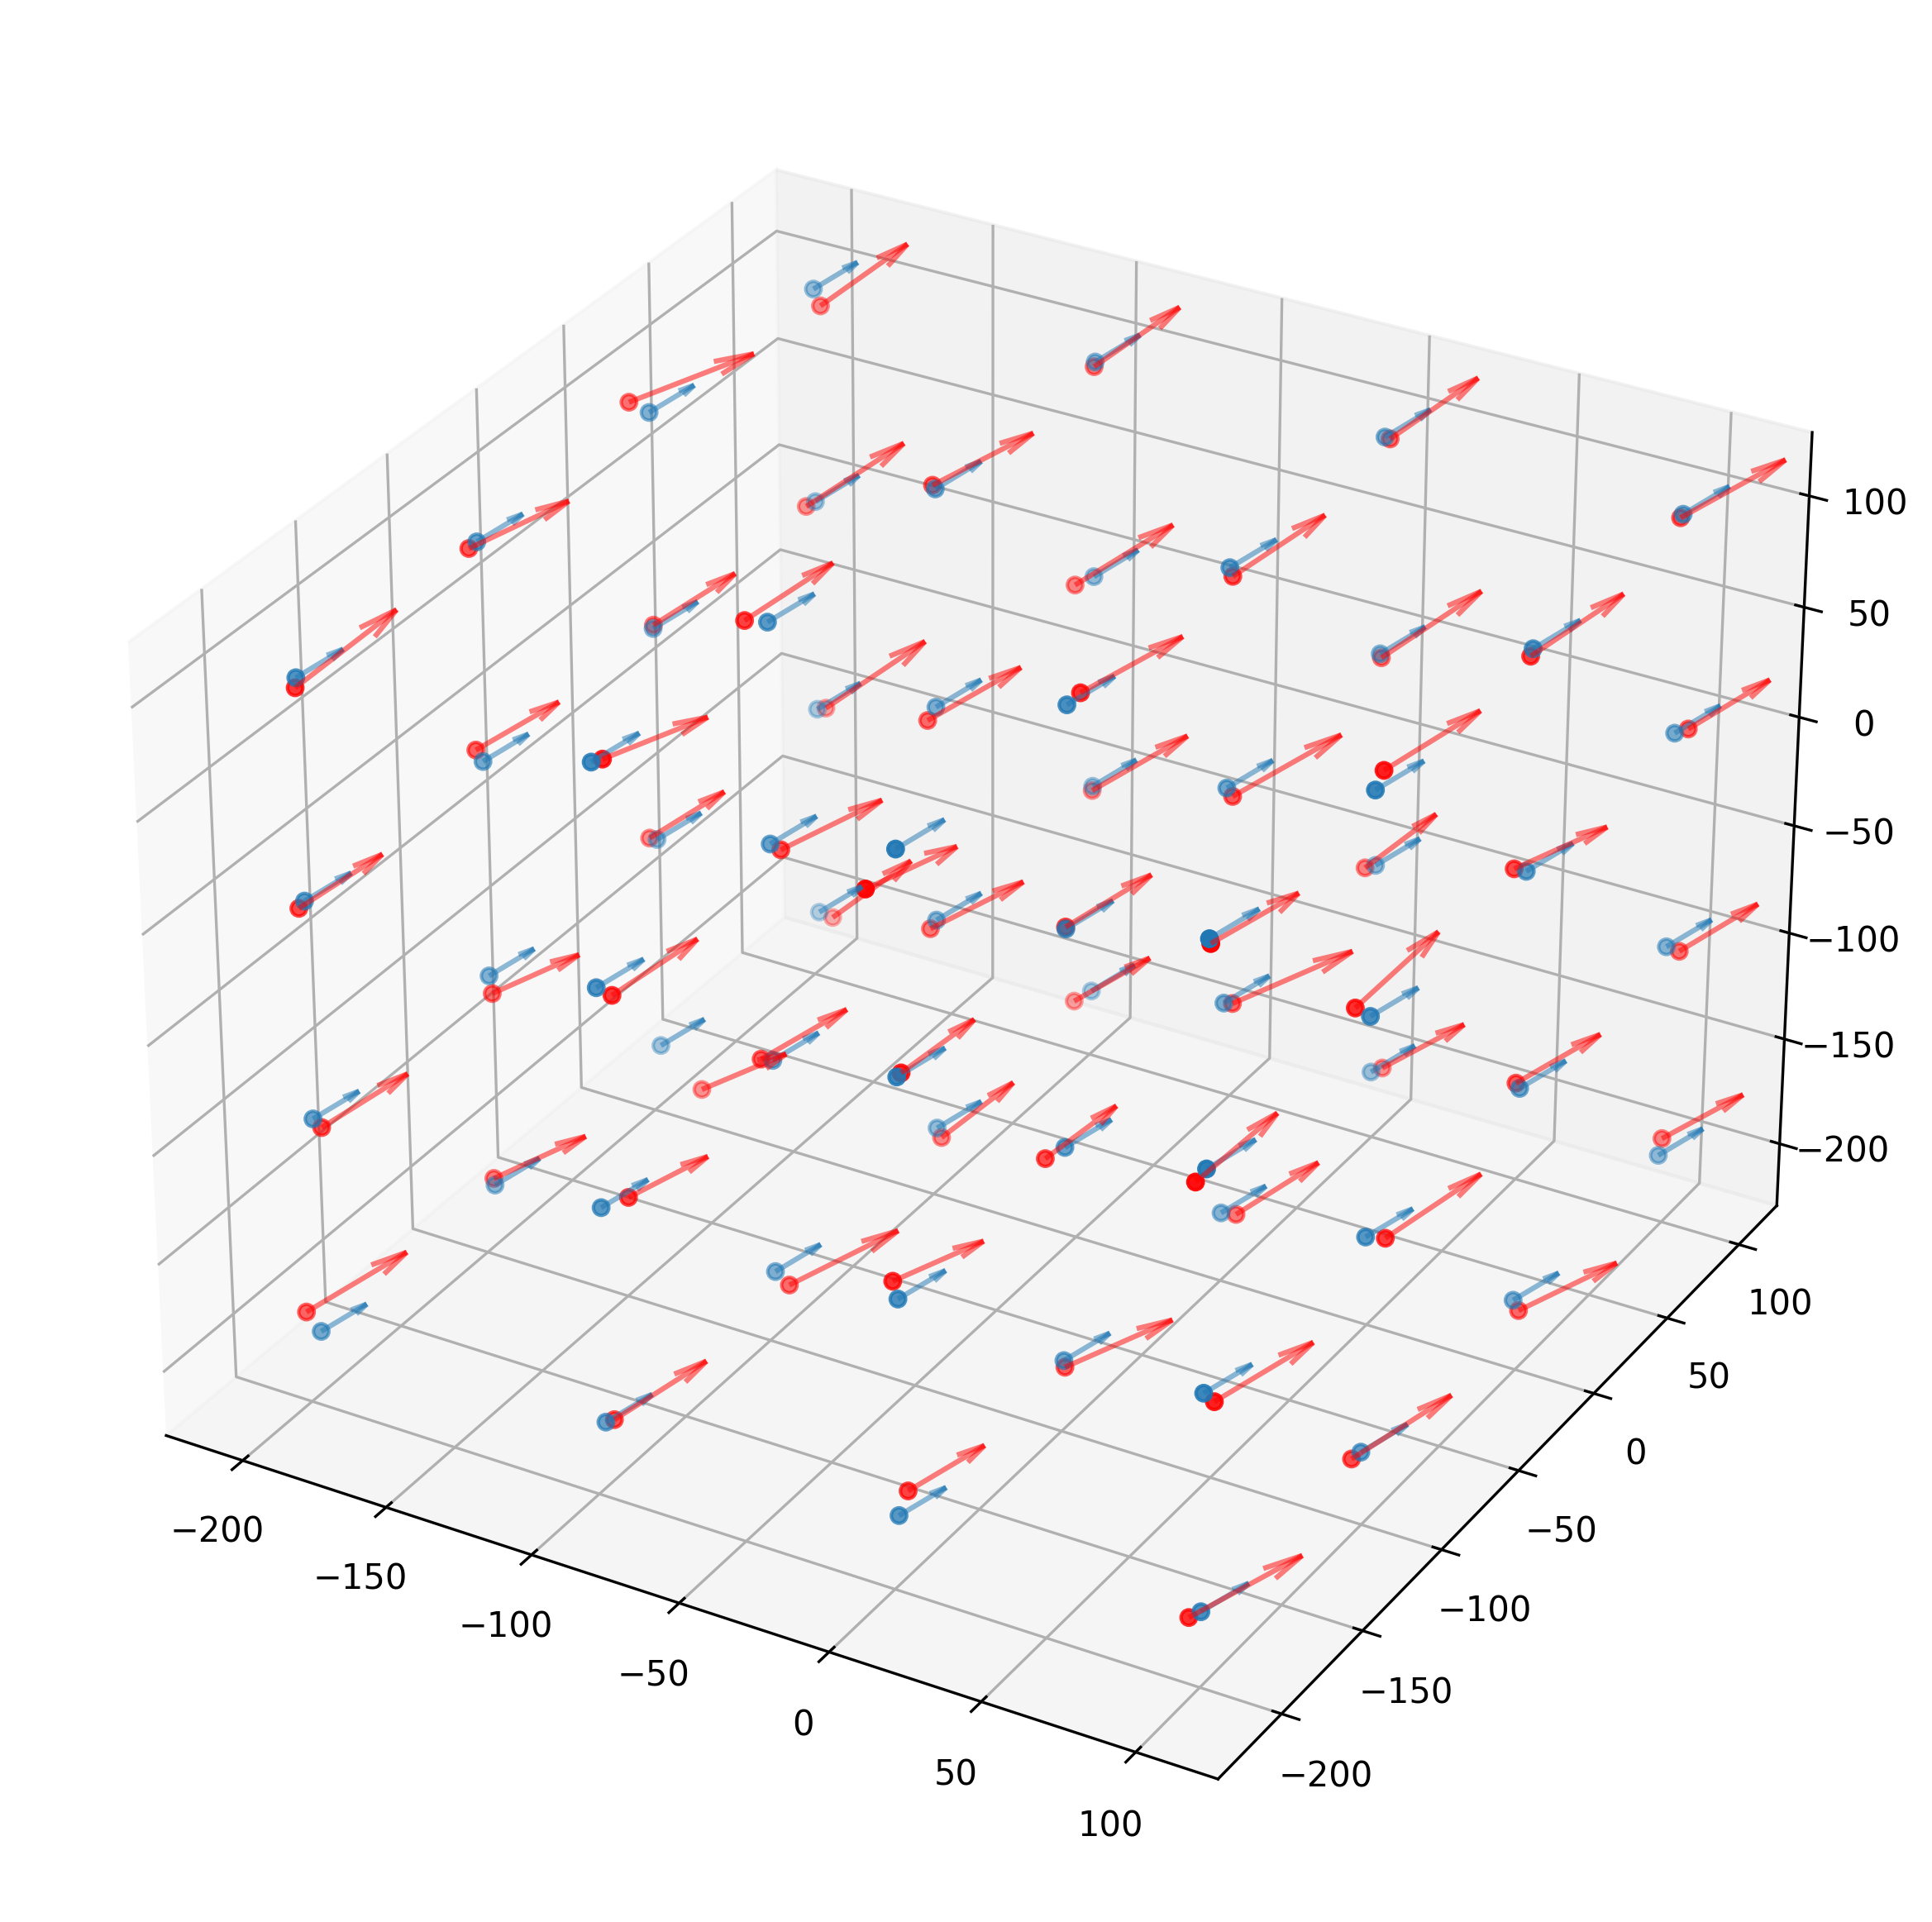

In [9]:
vlen = 10
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.axes(projection="3d")

ax.scatter3D(
    og_coords[:, 0], og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid"
)

ax = fig.gca(projection="3d")
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    length=vlen,
    label="Sample Space Tangents",
    alpha=0.5,
)

new_coords = ct.evaluate(og_coords)
print(
    f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}"
)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1, 1, 1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    label="Transformed Grid",
    color="red",
)
ax.quiver(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    new_derivs[:, 0],
    new_derivs[:, 1],
    new_derivs[:, 2],
    length=vlen,
    color="red",
    label="Transformed Tangents",
    alpha=0.5,
)
# # ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], new_coords[:,0]-og_coords[:,0],new_coords[:,1]-og_coords[:,1],new_coords[:,2]-og_coords[:,2], length=20, color='blue', label="Scaled Displacement Field")
# ax.legend(fontsize=17)

In [50]:
new_derivs

array([[-9.80821817e+02,  5.10889337e+01, -6.52529608e+02],
       [-5.58339493e+02, -6.31327783e+02, -3.16113698e+02],
       [-6.02912696e+02, -5.98550151e+02,  5.08745180e+00],
       [-5.96061119e+02, -5.95059849e+02,  3.04822258e+02],
       [-6.01154051e+02, -3.00339163e+02, -5.87287798e+02],
       [-6.09531976e+02, -2.73101097e+02, -2.82461697e+02],
       [-5.94929242e+02, -2.86870739e+02,  1.12638958e+00],
       [-5.86051971e+02, -3.02897049e+02,  2.87229587e+02],
       [-5.81383294e+02,  2.43059794e+00, -5.91113664e+02],
       [-5.83003805e+02,  2.88740354e-01, -3.02372671e+02],
       [-5.61106784e+02,  9.28212689e+00, -1.26682136e+01],
       [-5.84478397e+02,  5.61888229e+00,  2.97156085e+02],
       [-6.06339859e+02,  3.16613798e+02, -5.99881605e+02],
       [-5.97801478e+02,  3.00046397e+02, -3.08171043e+02],
       [-5.63570467e+02,  2.81390130e+02,  1.92138270e+01],
       [-5.94986129e+02,  3.01564672e+02,  3.12924524e+02],
       [-2.94847265e+02, -5.89983662e+02, -5.97346828e+02],
       [-3.09593176e+02, -6.06852176e+02, -2.55609920e+02],
       [-2.90544556e+02, -5.97271198e+02,  2.95803976e+00],
       [-3.02977029e+02, -5.78310345e+02,  2.95315050e+02],
       [-3.07968135e+02, -2.93598652e+02, -5.93717928e+02],
       [-3.02535349e+02, -3.03217522e+02, -3.03524634e+02],
       [-2.77202361e+02, -2.98124294e+02,  1.12031936e+01],
       [-2.93015959e+02, -2.99148182e+02,  2.98744765e+02],
       [-2.73120009e+02,  1.86899002e+01, -5.84697481e+02],
       [-2.97760949e+02,  3.33526870e+00, -2.85322503e+02],
       [-2.97117655e+02, -2.06776272e+00,  1.53754353e+01],
       [-2.82309107e+02,  9.35533165e+00,  2.93815973e+02],
       [-2.93321689e+02,  3.00099776e+02, -5.89069300e+02],
       [-3.03931553e+02,  2.92734511e+02, -2.93226458e+02],
       [-2.99859513e+02,  2.91122595e+02,  4.83343024e+00],
       [-3.07998299e+02,  2.98982435e+02,  2.95725323e+02],
       [-9.39000370e+00, -5.93214826e+02, -5.75254537e+02],
       [ 1.09775916e+01, -5.84210307e+02, -2.99355868e+02],
       [ 1.63651660e+01, -6.00336559e+02,  9.89335965e+00],
       [-6.40864722e-01, -6.10025316e+02,  3.02465651e+02],
       [ 7.37809679e+00, -2.91798991e+02, -5.91533111e+02],
       [ 1.55977049e+01, -2.89583731e+02, -2.80067551e+02],
       [ 6.72918855e+00, -2.92274811e+02, -5.40066342e+00],
       [-4.60968866e+00, -2.96177129e+02,  3.08170275e+02],
       [-3.45416334e+00, -6.07741839e+00, -6.03751782e+02],
       [ 6.87559384e+00,  3.74698237e+00, -3.03896362e+02],
       [-1.08784793e+01, -8.33028801e-01,  3.46318483e+00],
       [ 7.21658689e+00, -1.99389230e+00,  3.07007815e+02],
       [-2.23740540e+00,  3.03931555e+02, -5.84959840e+02],
       [ 1.33386667e+01,  3.02298794e+02, -2.99818225e+02],
       [ 3.04027452e+00,  2.94226355e+02, -3.05417164e+00],
       [-9.07580529e+00,  2.97611181e+02,  3.07358112e+02],
       [ 3.12650868e+02, -5.94543225e+02, -5.81369530e+02],
       [ 2.97420057e+02, -5.90885422e+02, -2.92935766e+02],
       [ 3.01901756e+02, -6.00365344e+02,  4.83352727e+00],
       [ 2.99625081e+02, -6.01201981e+02,  3.09761526e+02],
       [ 3.10118542e+02, -2.91626391e+02, -5.91628293e+02],
       [ 2.91088337e+02, -2.96199184e+02, -2.97319053e+02],
       [ 3.06138103e+02, -2.91029394e+02,  3.98775284e+00],
       [ 2.98353833e+02, -2.98058275e+02,  3.01790877e+02],
       [ 2.96332490e+02,  2.81341875e+00, -5.76758946e+02],
       [ 2.95340060e+02, -7.49605711e+00, -2.99709822e+02],
       [ 3.03924408e+02,  6.92068539e+00,  3.49455528e+00],
       [ 2.99037835e+02, -1.10875337e+01,  3.01804364e+02],
       [ 2.87207196e+02,  3.06424330e+02, -5.92642127e+02],
       [ 2.87713771e+02,  2.91619639e+02, -3.01406059e+02],
       [ 2.94961409e+02,  2.91770897e+02, -3.15364716e+00],
       [ 2.98818272e+02,  3.00397249e+02,  2.86393991e+02]])